# Explore: Web Coverage Processing Service

This notebook explores use of WCPS for complex raster array query operations. It makes use of async code utilized by SNAP's data API for making the requests, although that is not necessary and other packages like `requests` would work just fine.

In [1]:
import asyncio
import io
import time
import matplotlib.pyplot as plt
import xarray as xr
from aiohttp import ClientSession
from flask import request
from urllib.parse import quote

In [2]:
# just using the API code for ease
async def make_netcdf_request(url, session):
    """Make an awaitable GET request to WCS URL with
    netCDF encoding
    Args:
        url (str): WCS query with ncetCDF encoding
        session (aiohttp.ClientSession): the client session instance
    Returns:
        Query result, deocded differently depending on encoding.
    """
    resp = await session.get(url)
    resp.raise_for_status()
    query_result = await resp.read()

    return query_result

#### Average subset of grid over decades for single model/scenario/season

Computes the pixel-wise average for X = (200000, 1000000) and Y = (200000, 1000000), model = 0, scenario = 0, season = 0

Elapsed time: 0s
<xarray.Dataset>
Dimensions:  (varname: 2, X: 401, Y: 401)
Coordinates:
  * X        (X) float64 1.998e+05 2.018e+05 2.038e+05 ... 9.978e+05 9.998e+05
  * Y        (Y) float64 9.994e+05 9.974e+05 9.954e+05 ... 2.014e+05 1.994e+05
  * varname  (varname) float64 0.0 1.0
Data variables:
    Gray     (varname, X, Y) float32 ...
Attributes:
    Title:    Seasonal-decadal summaries of AR5 temperature and precipitation...


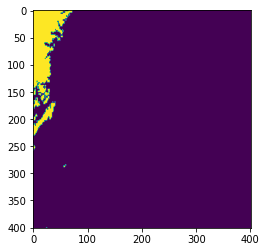

In [3]:
wcps_query = quote('for $c in (iem_ar5_2km_taspr_seasonal) return encode(condense + over $t decade(imageCrsDomain($c[decade(6:8)], decade)) using $c[decade($t),model(0),scenario(0),season(0),X(200000:1000000),Y(200000:1000000)], "application/netcdf")')
url = f"http://zeus.snap.uaf.edu:8080/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&request=ProcessCoverages&query={wcps_query}"

start_time = time.time()
async with ClientSession() as session:
    netcdf_bytes = await asyncio.create_task(make_netcdf_request(url, session))

ds = xr.open_dataset(io.BytesIO(netcdf_bytes))
    
print(f"Elapsed time: {round(time.time() - start_time)}s")
print(ds)

plt.imshow(ds["Gray"].sel(varname=0).values)

##### Larger area...

Computes the same as above but for a larger portion of the domain.

Elapsed time: 1s
<xarray.Dataset>
Dimensions:  (varname: 2, X: 2001, Y: 901)
Coordinates:
  * X        (X) float64 -2e+06 -1.998e+06 -1.996e+06 ... 1.998e+06 2e+06
  * Y        (Y) float64 1.999e+06 1.997e+06 1.995e+06 ... 2.014e+05 1.994e+05
  * varname  (varname) float64 0.0 1.0
Data variables:
    Gray     (varname, X, Y) float32 ...
Attributes:
    Title:    Seasonal-decadal summaries of AR5 temperature and precipitation...


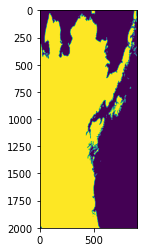

In [4]:
wcps_query = quote('for $c in (iem_ar5_2km_taspr_seasonal) return encode(condense + over $t decade(imageCrsDomain($c[decade(6:8)], decade)) using $c[decade($t),model(0),scenario(0),season(0),X(-2000000:2000000),Y(200000:2000000)], "application/netcdf")')
url = f"http://zeus.snap.uaf.edu:8080/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&request=ProcessCoverages&query={wcps_query}"

start_time = time.time()
async with ClientSession() as session:
    netcdf_bytes = await asyncio.create_task(make_netcdf_request(url, session))

ds = xr.open_dataset(io.BytesIO(netcdf_bytes))
    
print(f"Elapsed time: {round(time.time() - start_time)}s")
print(ds)

plt.imshow(ds["Gray"].sel(varname=0).values)